# Nettoyage des données
Created by: Thomas Durand-Texte, Jan. 2023

# Import des packages

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option("display.max_columns", 200)
import missingno as msno

import datetime as dt
import scipy.stats as st


import matplotlib.pyplot as plt
import seaborn as sns


import tools
cm = 1./2.54


# Reload module (for updates)

In [2]:
import importlib
cm = 1./2.54
importlib.reload(tools)
tools.set_theme( white_font=True )
# tools.plot_test_figure()

# Lectures des différentes catégories
<span style="color:red"> **Lire et compter empty cells ?** </span>
<span style="color:red"> **Autre méthode rapide ?** </span>

In [3]:
with open('openfood_OC.csv' , 'r') as file:
    categories_0 = file.readline()[:-1].split('\t')
    # print('n \\t: {:}'.format( len(line.split('\t')) ) )
    # print(line)
    # while True:
    #     line = file.readline()[:-1]
    #     if line is None: break    
    # print(file.readline())
    # print(file.readline())
print('categories:', categories_0 )

categories: ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'packaging_en', 'packaging_text', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil',

# Définitions keys to keep/drop

In [4]:
# lst of keywords for categories that must be kept
keep_keys = '|'.join( ['nutriscore', 'labels'] )
# lst of keywords for categories that must be dropped
drop_keys = '|'.join( ['image', 'brands', 'url', 'abbreviated_product_name', 'generic_name', 'packaging'] )

categories = pd.Series( categories_0 )[~pd.Series( categories_0 ).str.contains( drop_keys ) ].to_list()
# print( categories_to_load )

# chargement des données

In [9]:
data = pd.DataFrame()

dtypes = { key:'category' for key in ['nova_group', 'nutriscore_grade'] }

for key in ['code', 'traces', 'traces_en', 'traces_tags',
            'origins_en', 'origins_tags', 'purchase_places',
            'manufacturing_places', 'manufacturing_places_tags',
            'origins', 'food_groups_tags','ingredients_from_palm_oil_tags',
            'ingredients_that_may_be_from_palm_oil_tags',
            'emb_codes_tags', 'food_groups', 'food_groups_en',
            'cities_tags', 'ecoscore_grade_fr', 'emb_codes',
            'allergens', 'additives',
            ]:
    dtypes[key]= 'object'


# data = dd.read_csv( 'openfood_OC.csv', delimiter='\t', usecols=categories, dtype=dtypes )
# data = data.compute()

data = pd.read_csv( 'openfood_OC.csv', delimiter='\t', usecols=categories, dtype=dtypes )


# data.head()

# dtype = { 'nova_group':'category', 'nutriscore_grade':'category', 'additives': 'object' , 'abbreviated_product_name': 'object', 'allergens': 'object', 'cities_tags': 'object', 'code': 'object', 'ecoscore_grade_fr': 'object', 'emb_codes': 'object', 'emb_codes_tags': 'object', 'first_packaging_code_geo': 'object', 'food_groups': 'object', 'food_groups_en': 'object', 'food_groups_tags': 'object', 'generic_name': 'object', 'ingredients_from_palm_oil_tags': 'object', 'ingredients_that_may_be_from_palm_oil_tags': 'object', 'manufacturing_places': 'object', 'manufacturing_places_tags': 'object', 'origins': 'object', 'origins_en': 'object', 'origins_tags': 'object', 'packaging_text': 'object', 'purchase_places': 'object', 'traces': 'object', 'traces_en': 'object', 'traces_tags': 'object'}



# data = dd.read_csv('openfood_OC.csv', delimiter ='\t', dtype=dtype)
# data = data.compute()

# # data = pd.read_csv('openfood_OC.csv', delimiter='\t', dtype=dtype)
# data.head()

# Détection des doublons
<span style="color:red"> Gestion des dulicatas ? merge ? how to ? </span>

<span style="color:yellow"> Regarder uniquement duplicatas COMPLETS </span>

<span style="color:yellow"> code : prendre le plus récent / plus complet (regarder nombre nan) </span>

In [16]:
duplicated_codes = data['code'].duplicated(keep=False)
duplicated_full = data.loc[duplicated_codes,:].duplicated(keep=False)
display( duplicated_full )

61995     False
188851    False
270028    False
349035    False
421527    False
477267    False
480000    False
749882    False
dtype: bool

In [17]:

df_tmp = data.loc[diplicated_codes, :]
df_tmp['sum_nan'] = df_tmp.isnull().sum(1)
# display( df_tmp[['code', 'created_datetime', 'last_modified_datetime', 'sum_nan']] )
display( df_tmp )

/tmp/ipykernel_6120/3420838785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['sum_nan'] = df_tmp.isnull().sum(1)


,code,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,food_groups,food_groups_tags,food_groups_en,states,states_tags,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,soluble-fiber_100g,insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,sum_nan
61995,3560070278831,openfoodfacts-contributors,1381071983,2013-10-06T15:06:23Z,1618645457,2021-04-17T07:44:17Z,"Pamplemousse rose, 100 % Pur Fruit Pressé",1 L e,"en:plant-based-foods-and-beverages,en:beverage...","en:pure-grapefruit-juice,en:beverages,en:fruit...","Pure-grapefruit-juice,Beverages,Fruit-based be...",NaN,NaN,NaN,Laiterie de Varennes (Filiale Laiterie de Sain...,laiterie-de-varennes-filiale-laiterie-de-saint...,"en:distributor-labels,en:carrefour-quality,en:...","en:carrefour-quality,en:distributor-labels,en:...","Carrefour Quality,Distributor labels,Green Dot...","EMB 36229,EMB 45273,EMB 67434,emb-36229m","emb-36229,emb-45273,emb-67434,emb-36229m",NaN,"varennes-sur-fouzon-indre-france,saint-denis-d...","Rouen,France",Carrefour,France,en:france,France,"Jus de pamplemousse rose, pulpe (2%).",NaN,NaN,NaN,NaN,NaN,200ml,200.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,2.0,c,1.0,Beverages,Fruit juices,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrit

# Visiualisation of NaN with missingno
as barplot 

In [ ]:
msno.bar( data )

# Remove empty and some usused/unusable? columns

In [14]:
n = len(data) # number of samples
sum_isnull = data.isnull().sum() # number of null data for each column

In [15]:
n_null_lim_drop = int(0.7*n)

categories_full = sum_isnull[ sum_isnull == 0].index.to_list()
print('\nFull categories:', categories_full)

categories_hollow = sum_isnull[ sum_isnull > n_null_lim_drop].index.to_list()
print('\nHollow categories:', categories_hollow)


# drop caterories to keep (with keep_keys)
removed_cat = pd.Series( categories_hollow )
removed_cat = removed_cat[ ~removed_cat.str.contains(keep_keys) ].to_list()

# check is completely empty categories remains
removed_cat += [ key for key in sum_isnull[ sum_isnull == n].index if not key in removed_cat ]

# check for dupplicated entry
removed_cat = [ key for i, key in enumerate( removed_cat ) if not key in removed_cat[:i] ]

# check if key are still in DataFrame
removed_cat = [key for key in removed_cat if key in data.keys()]
print('\nRemoved categories:', {key: sum_isnull[key] for key in removed_cat} )


# print('')
# data.memory_usage()

if True: data.drop( columns=removed_cat, inplace=True )
# if True: data = data.drop( columns=removed_cat )

# print('')
# data.memory_usage()

# msno.bar( data )


Full categories: ['code', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'states', 'states_tags', 'states_en']

Hollow categories: ['quantity', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'cities', 'cities_tags', 'purchase_places', 'stores', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'brand_owner', 'ecoscore_score_fr', 'ecoscore_grade_fr', 'energy-kj_100g', 'energy-from-fat_100g', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-ac

# Visualisation of NaN for new DataFrame

In [16]:
print(sum_isnull.size, len(categories), len(data.keys()))
with pd.option_context('display.max_rows', None):
    print( sum_isnull[data.keys()].sort_values() )

177 177 46
code                                                          0
created_t                                                     0
created_datetime                                              0
last_modified_t                                               0
last_modified_datetime                                        0
states_tags                                                   0
states                                                        0
states_en                                                     0
creator                                                       1
pnns_groups_2                                               108
pnns_groups_1                                               108
countries                                                  2300
countries_en                                               2301
countries_tags                                             2301
product_name                                              31080
energy_100g                  

<AxesSubplot: >

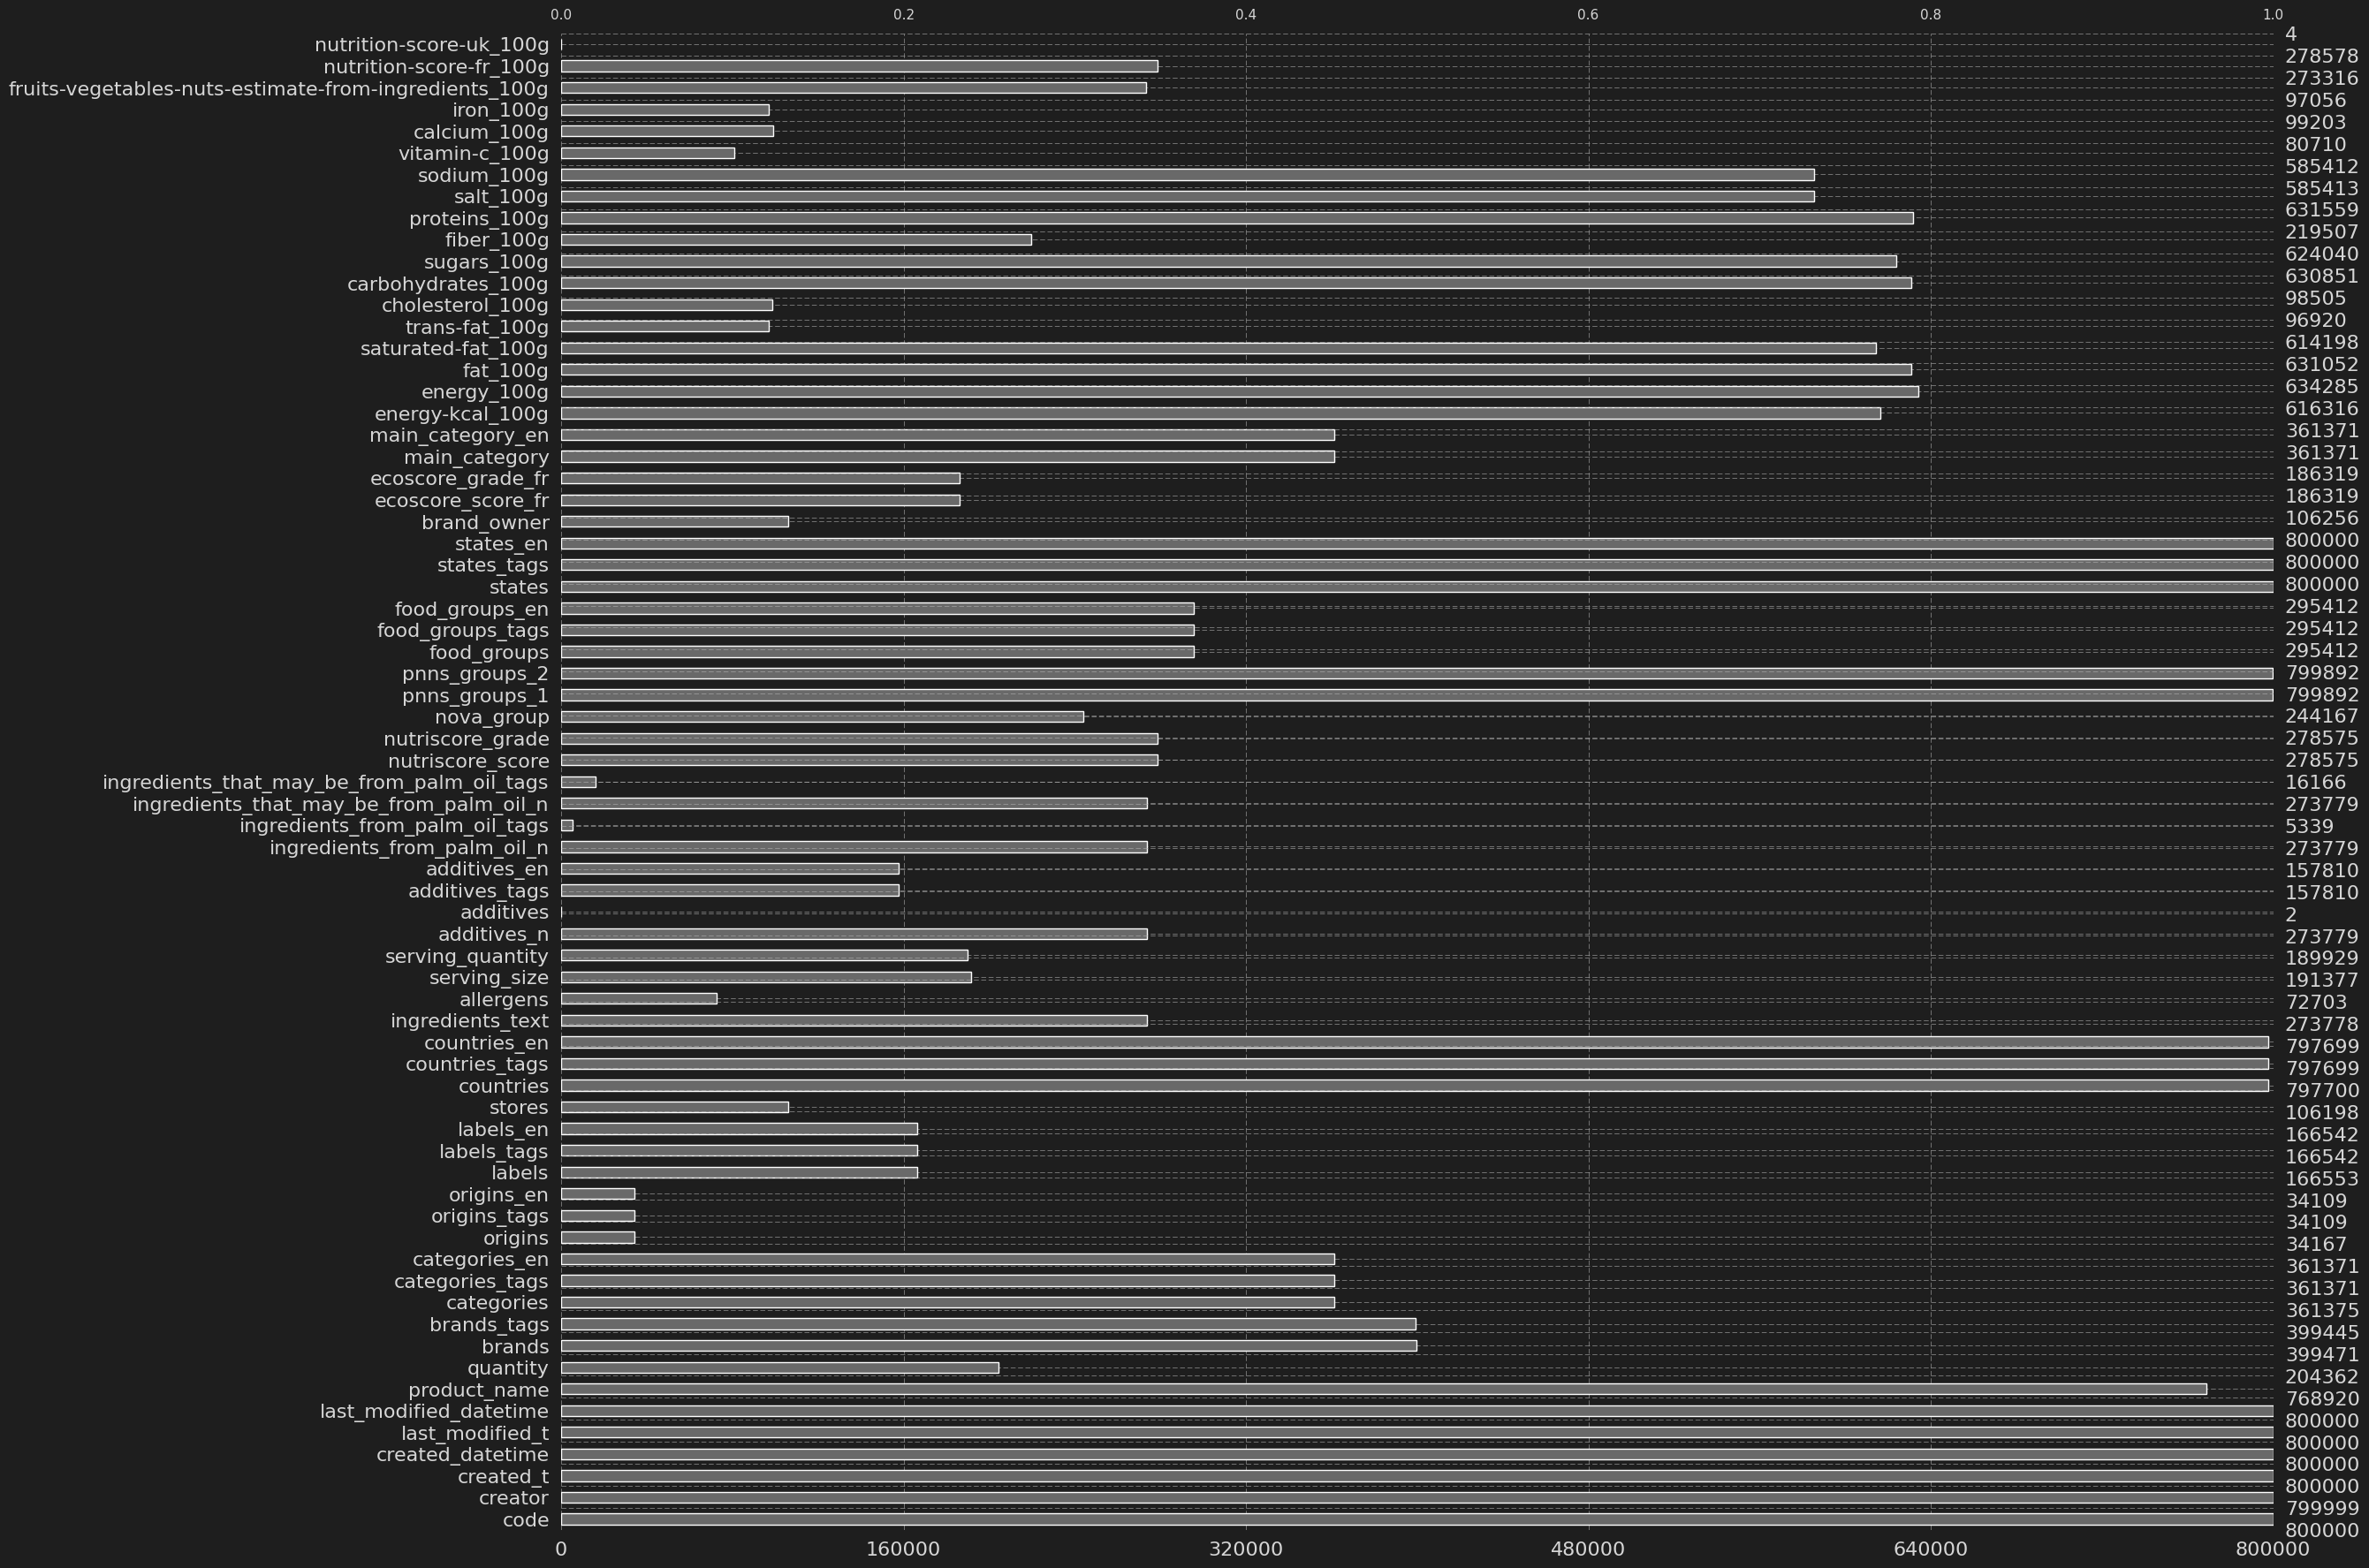

In [10]:
msno.bar( data )

# Heatmap without fully filled categories

<AxesSubplot: >

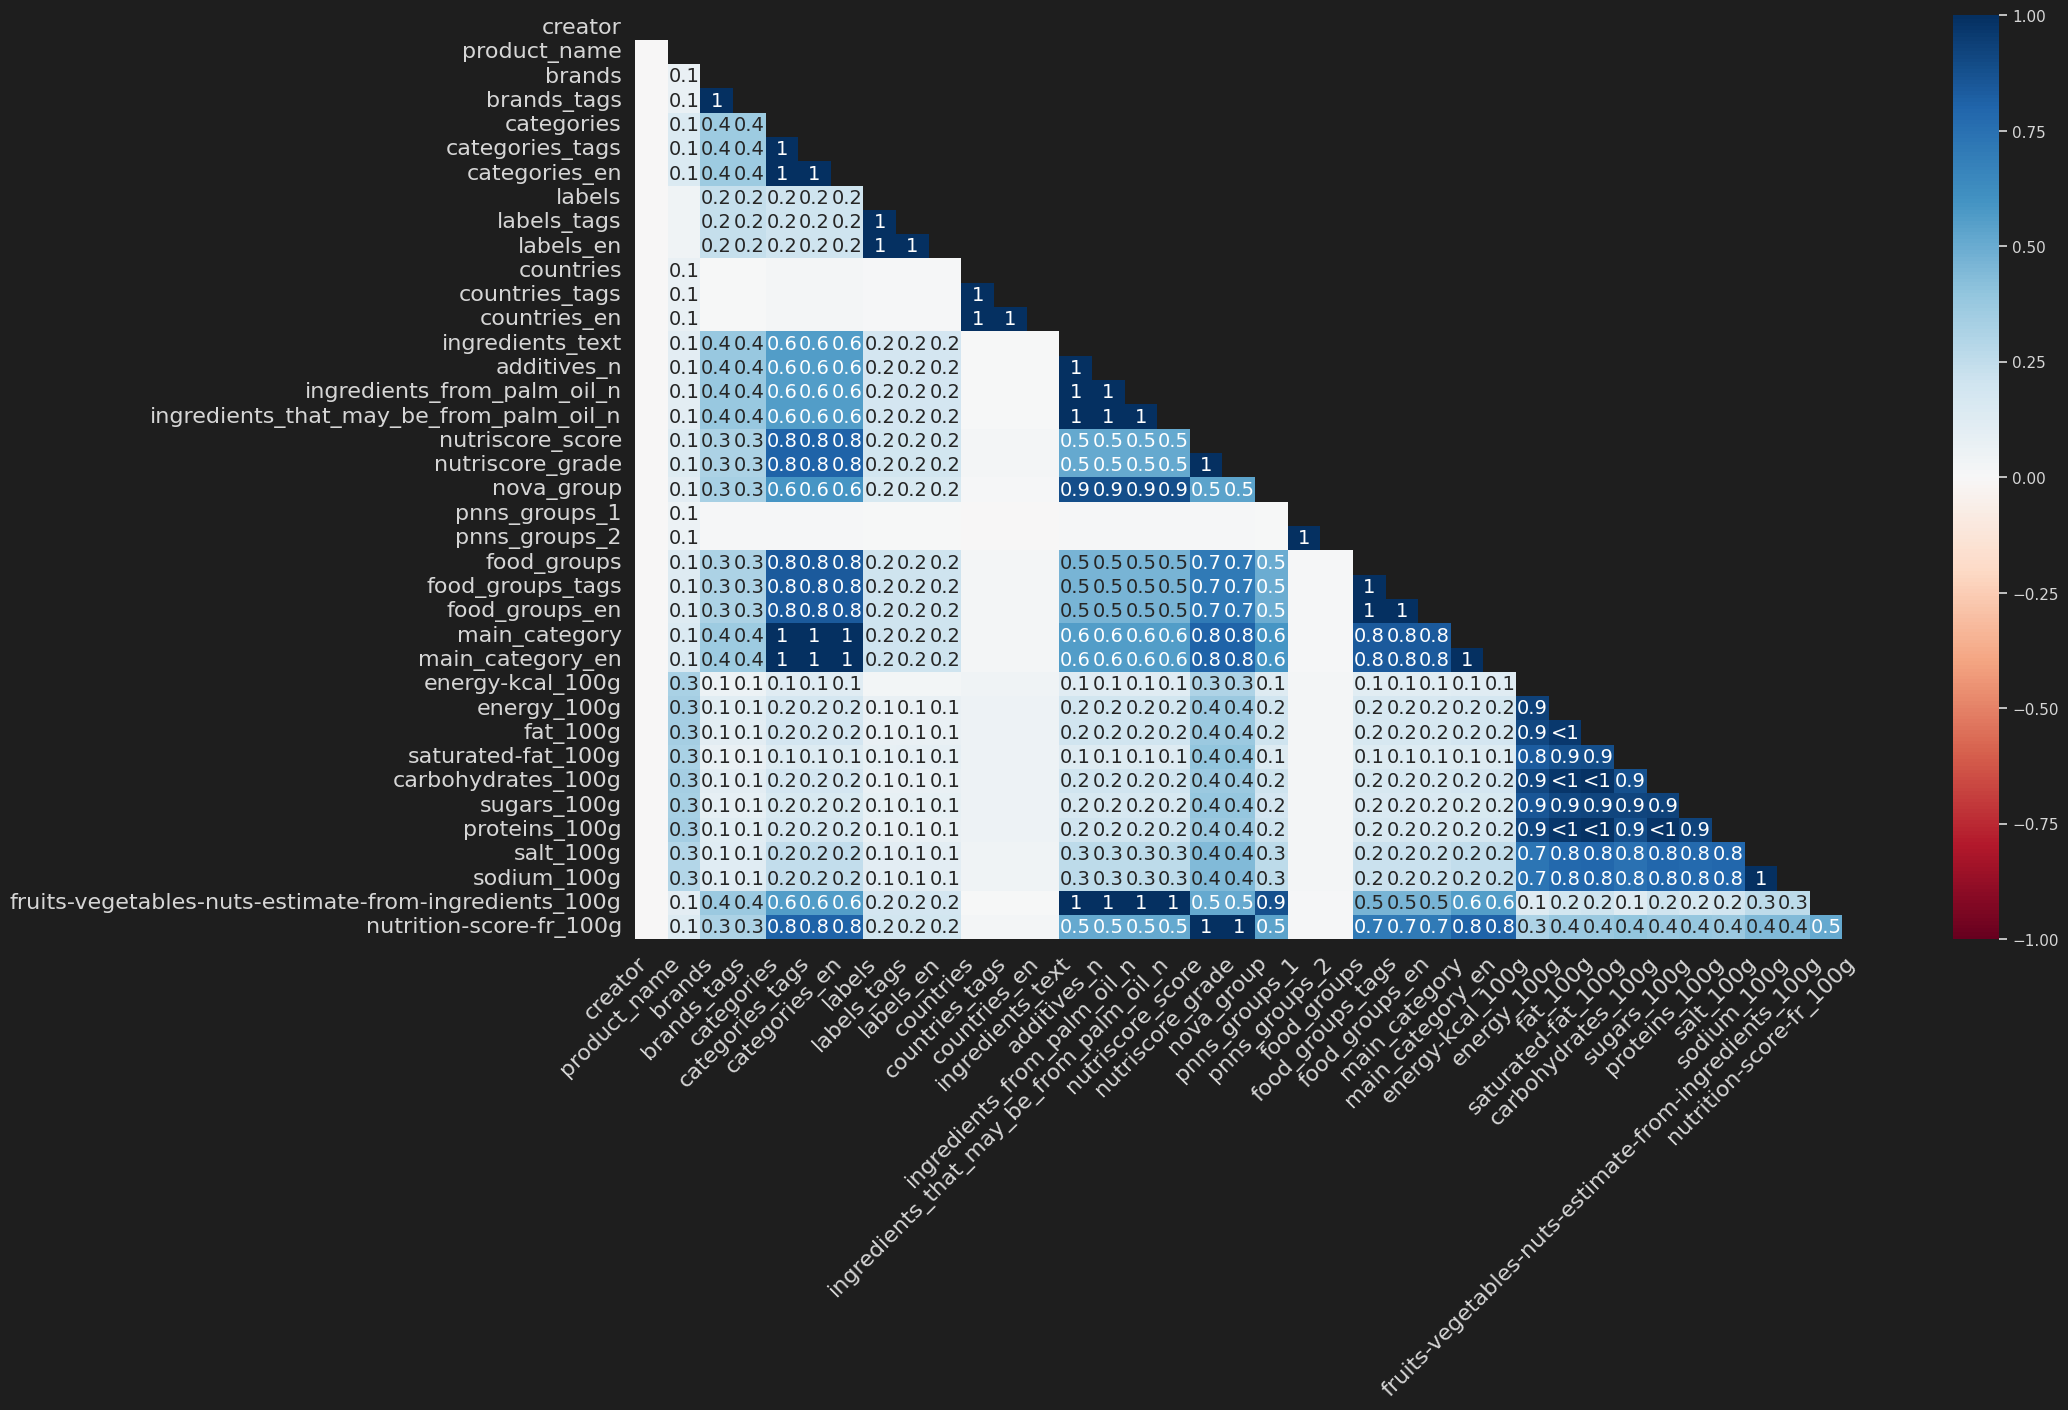

In [17]:
msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full)] ] )

# Heatmap without fully filled categories (qualitatives + nutriscore)

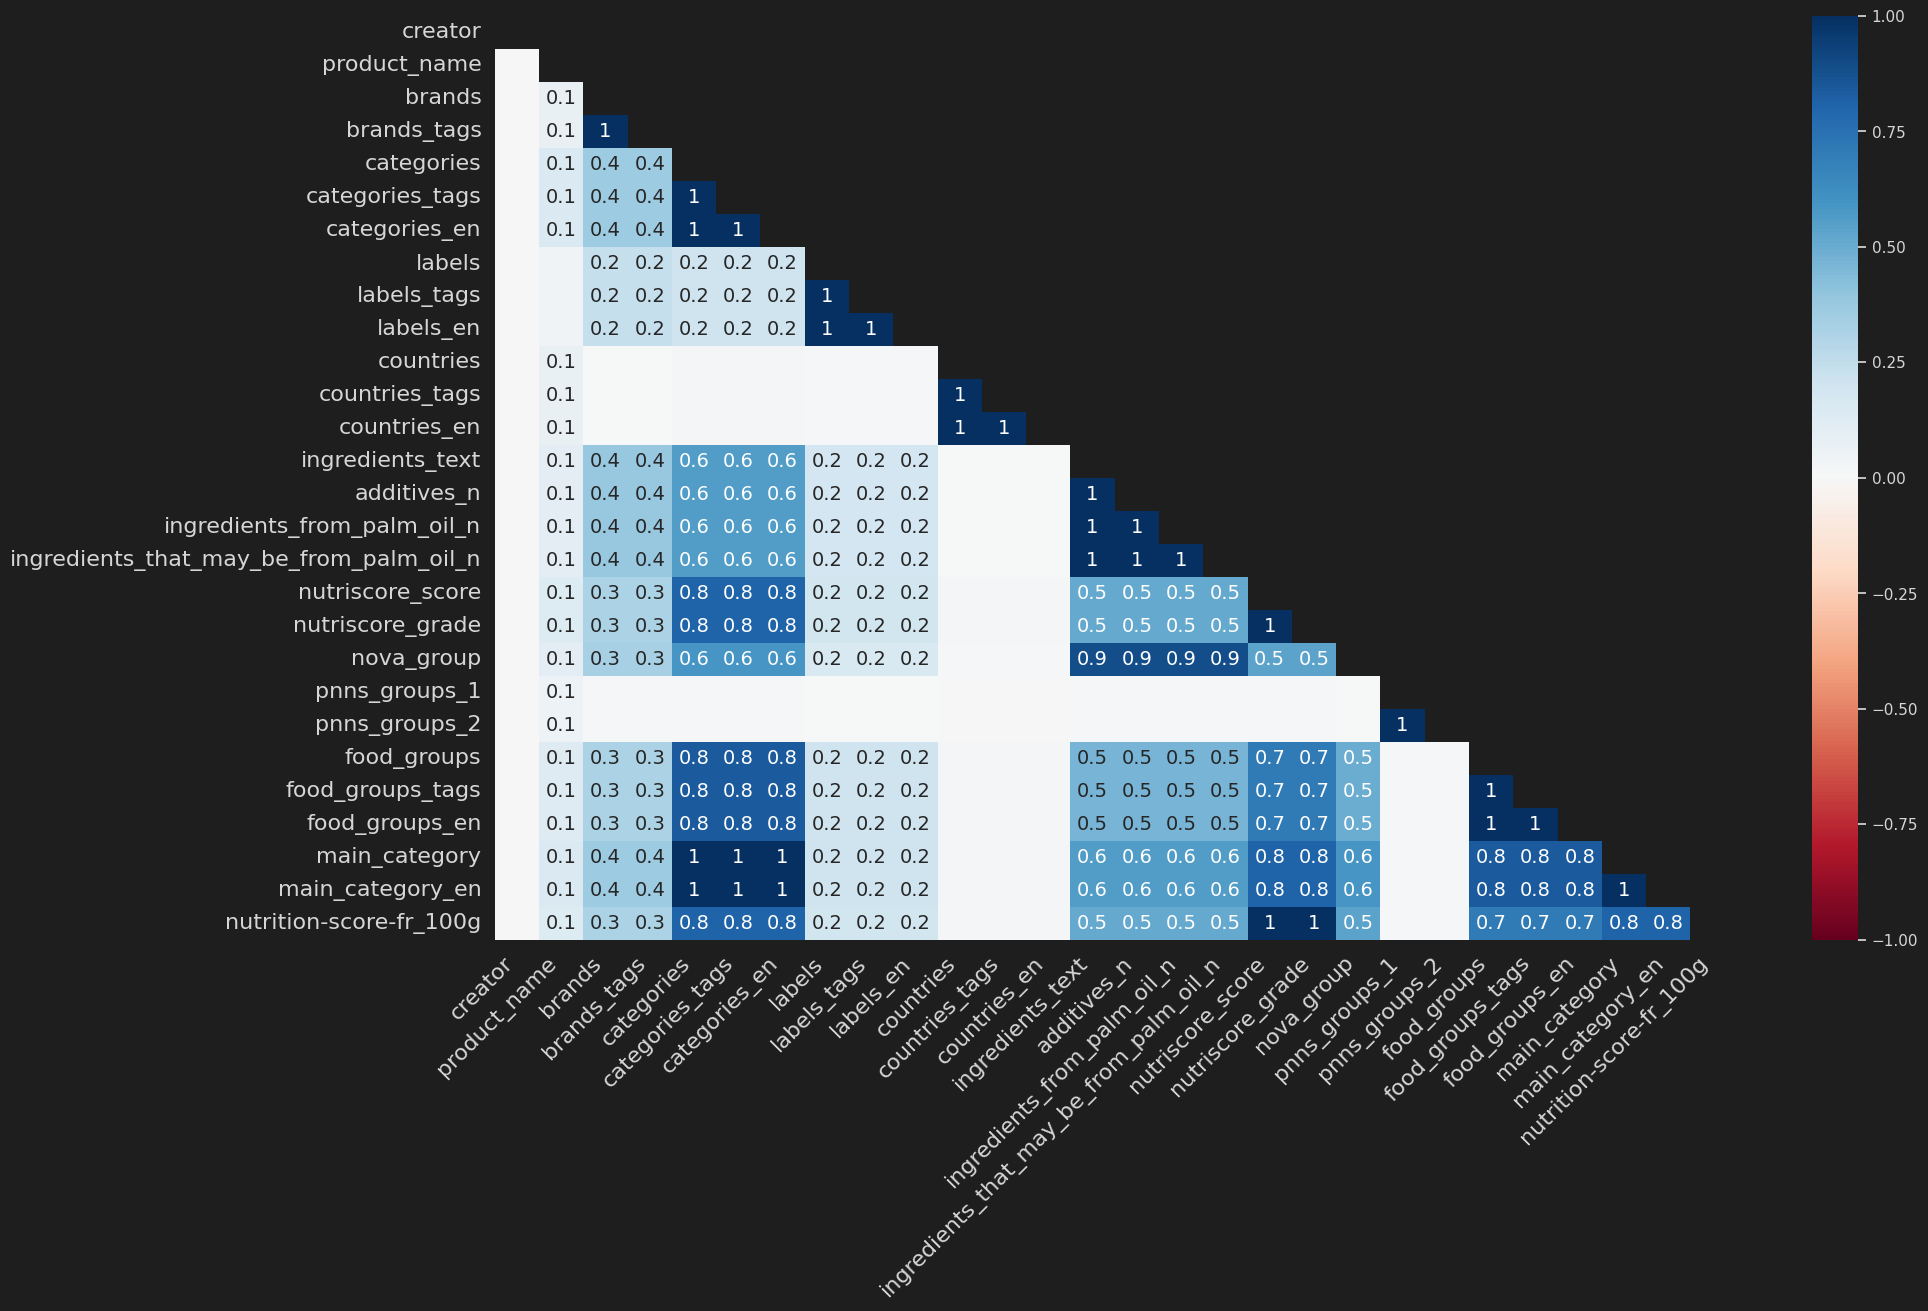

In [18]:
ax = msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full) and (not '_100g' in key) or 'score' in key] ] )

# DTYPES

In [32]:
with pd.option_context('display.max_rows', None):
    display(data.dtypes)

code                                                       object
creator                                                    object
created_t                                                   int64
created_datetime                                           object
last_modified_t                                             int64
last_modified_datetime                                     object
product_name                                               object
brands                                                     object
brands_tags                                                object
categories                                                 object
categories_tags                                            object
categories_en                                              object
labels                                                     object
labels_tags                                                object
labels_en                                                  object
countries 

# Listes des catégories: string / float64 / others

In [19]:
categories_float, categories_others = [], []
for cat in data.keys():
    if data.dtypes[cat] == 'float64': categories_float.append( cat )
    else: categories_others.append( cat )

categories_string = []
# print('\nstrings to lowercase')
for key in categories_others: 
    # print(key, 'type', data[key].dtype)
    if data[key].dtype != 'object': continue
    categories_string.append( key )
    # data[key].str.lower()

print("float categories:", categories_float )
print("\nstring categories:", categories_string )
print("\nothers categories:", categories_others )


float categories: ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'nutrition-score-fr_100g']

string categories: ['code', 'creator', 'created_datetime', 'last_modified_datetime', 'product_name', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'labels', 'labels_tags', 'labels_en', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'pnns_groups_1', 'pnns_groups_2', 'food_groups', 'food_groups_tags', 'food_groups_en', 'states', 'states_tags', 'states_en', 'main_category', 'main_category_en']

others categories: ['code', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'brands', 'brands_tags', 'categories', 'categories_tags', '

# Analyse variables category
1. str.lower
1. replace unknown in 'pnn_groups'
1. astype 'category'
1. print first values for each category

In [20]:
string_catergories_to_value_count = ['nova_group', 'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2', 'food_groups']


# lower all string
for key in string_catergories_to_value_count:
    print(key, data[key].dtype.kind)
    # if data[key].dtype.kind != 'O': continue # Check if dtyp is object
    if not pd.api.types.is_string_dtype( data[key].dtype ): continue
    data[key] = data[key].str.lower()

# replace 'unknown' to NaN
data.replace( {'pnns_groups_1':'unknown', 'pnns_groups_2':'unknown'}, np.nan, inplace=True )

# astype category
data[string_catergories_to_value_count] = data[string_catergories_to_value_count].astype('category')


for key in string_catergories_to_value_count:
    print('\n', key, data.dtypes[key])
    i = 0
    for value in data[key] :
        if pd.isnull( value ) : continue
        print(value )
        i += 1
        if i == 10: break
dico_value_counts = { key: data[key].value_counts().sort_values() for key in string_catergories_to_value_count }

nova_group O
nutriscore_grade O
pnns_groups_1 O
pnns_groups_2 O
food_groups O

 nova_group category
3.0
4.0
3.0
3.0
3.0
4.0
4.0
1.0
1.0
4.0

 nutriscore_grade category
d
e
d
a
d
b
b
b
a
d

 pnns_groups_1 category
beverages
milk and dairy products
beverages
fish meat eggs
fish meat eggs
milk and dairy products
fat and sauces
beverages
fish meat eggs
fish meat eggs

 pnns_groups_2 category
teas and herbal teas and coffees
dairy desserts
waters and flavored waters
fish and seafood
meat
cheese
dressings and sauces
fruit juices
meat
meat

 food_groups category
en:teas-and-herbal-teas-and-coffees
en:dairy-desserts
en:waters-and-flavored-waters
en:fish-and-seafood
en:poultry
en:cheese
en:dressings-and-sauces
en:unsweetened-beverages
en:poultry
en:poultry


,nova_group,nutriscore_grade,pnns_groups_1,pnns_groups_2,food_groups
0,4,5,10,40,46


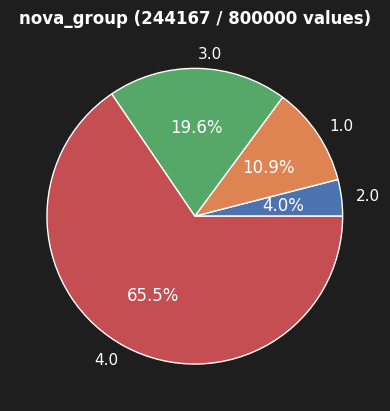

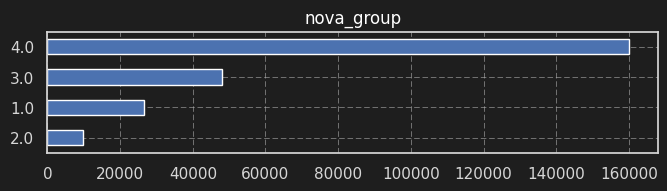

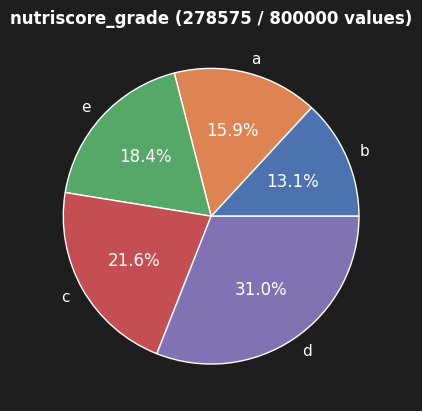

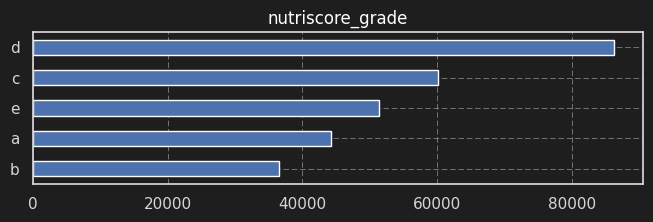

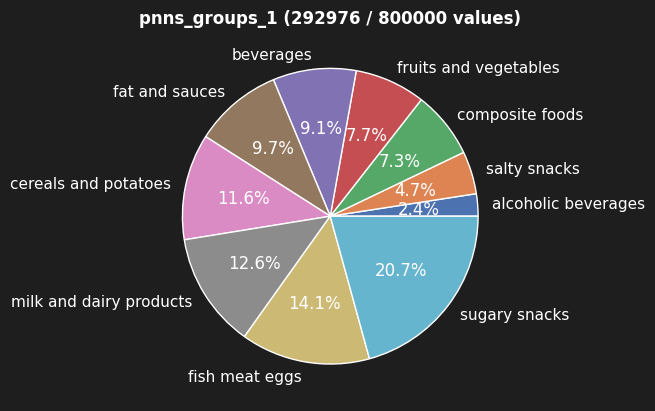

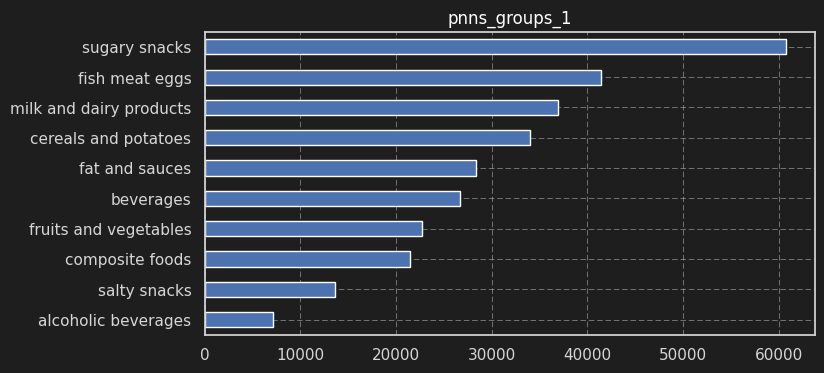

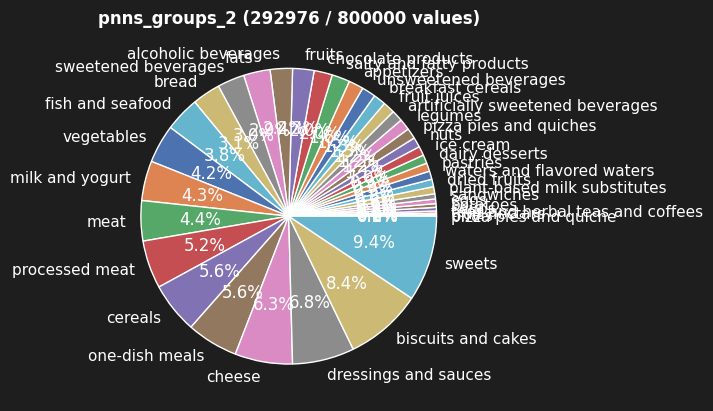

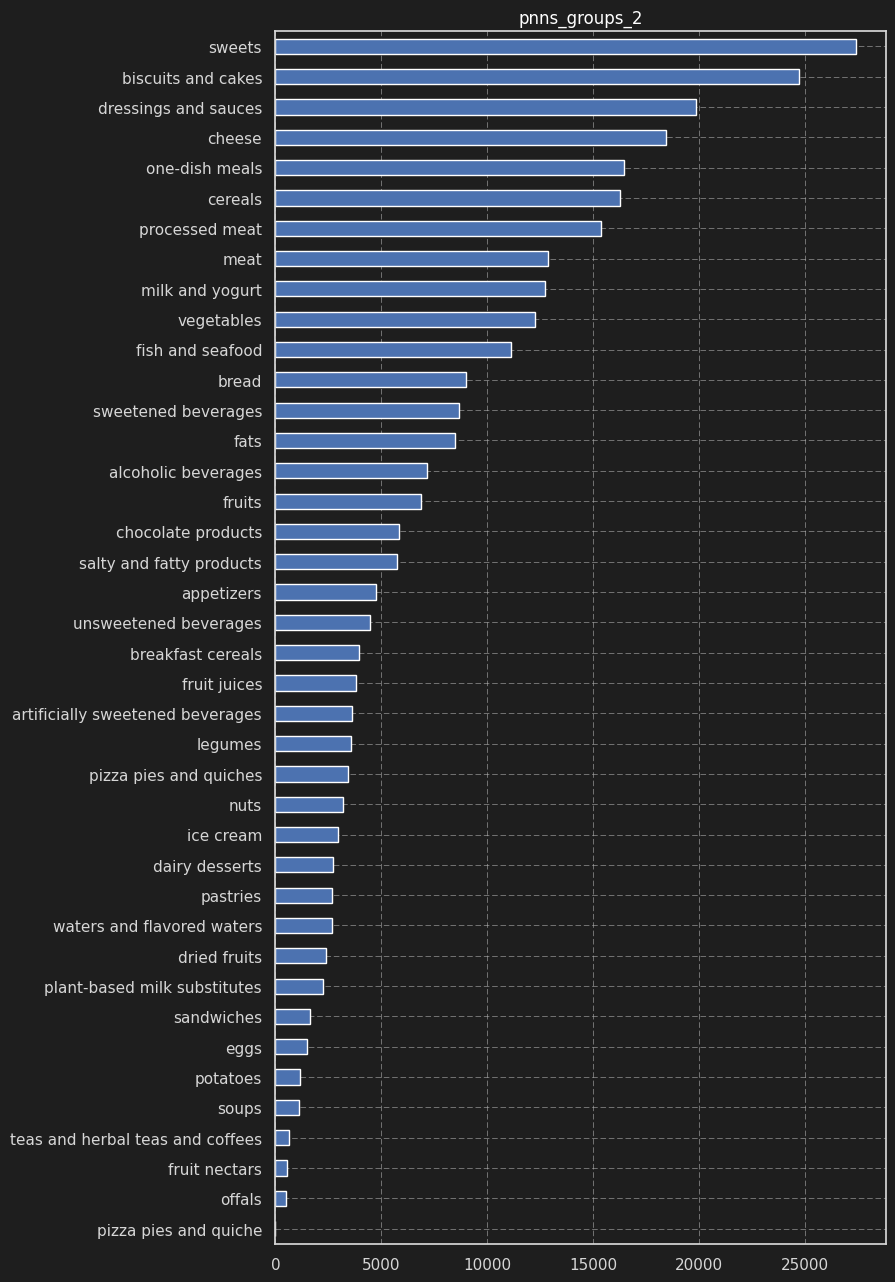

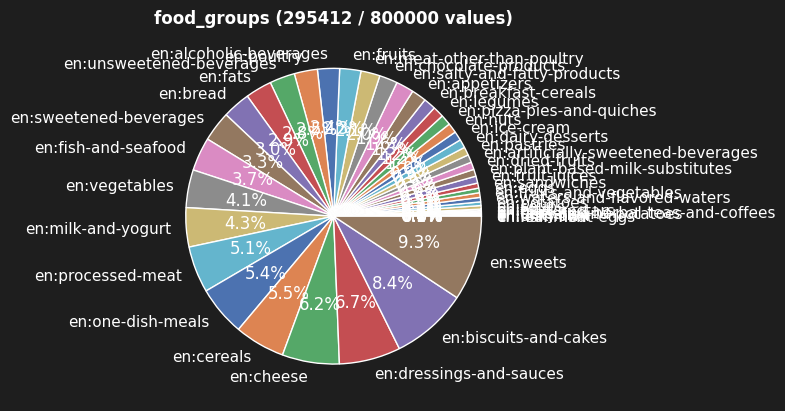

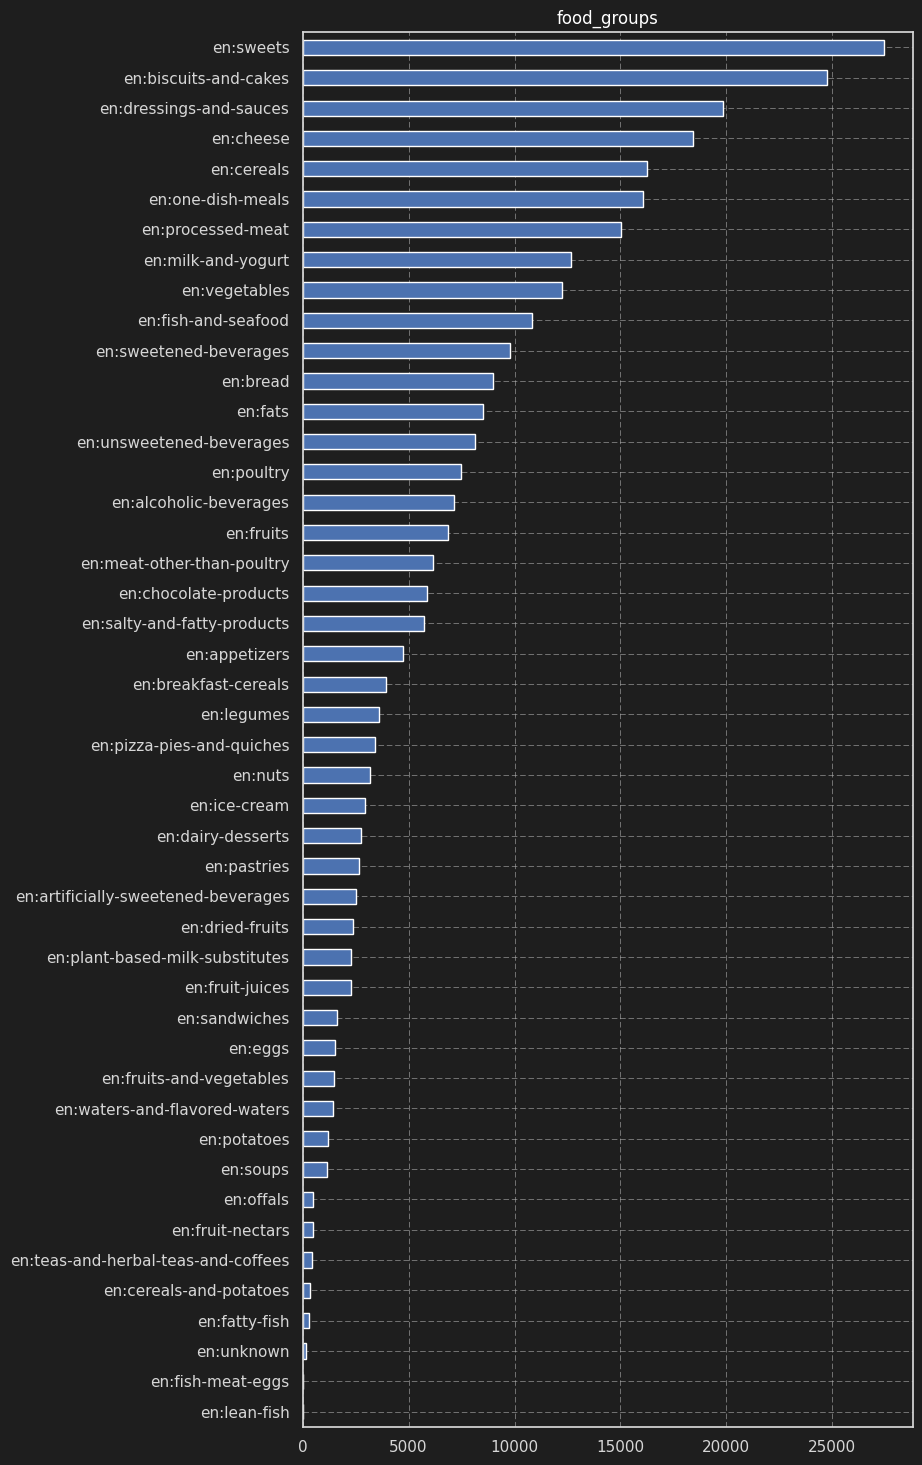

In [21]:
data_value_counts = pd.DataFrame( {key:[len(dico_value_counts[key])] for key in string_catergories_to_value_count} )
display(data_value_counts)
# data_value_counts.plot( kind='bar' )

# print('min counts', data_value_counts.iloc[0,:].min() )

for key in string_catergories_to_value_count:
    if data_value_counts[key][0] > 50: continue
    n_sum = dico_value_counts[key].sum()
    fig, ax = plt.subplots()
    pd.Series( dico_value_counts[key] ).plot( kind='pie' , ax=ax, autopct='%.1f%%' )
    ax.set_title( '{:} ({:} / {:} values)'.format( key, n_sum, n), weight='bold')
    ax.set_ylabel('')

    fig, ax = plt.subplots( figsize=(20*cm, 10*cm*(data_value_counts[key][0]/10)) )
    pd.Series( dico_value_counts[key] ).plot( kind='barh' , ax=ax )
    ax.set_title(key)

if False: # barplot
    cat_pos = np.arange( len(string_catergories_to_value_count) )
    print(cat_pos)
    fig, ax = plt.subplots( figsize=(20*cm,10*cm))
    if True: # horizontal
        ax.bar( cat_pos, data_value_counts.iloc[0,:] , align='center')
        ax.set_xticks(cat_pos, labels=string_catergories_to_value_count)
    else:
        ax.barh( cat_pos, data_value_counts.iloc[0,:] , align='center')
        ax.set_yticks(cat_pos, labels=string_catergories_to_value_count)
        ax.invert_yaxis()  # labels read top-to-bottom

    fig.tight_layout()
    del cat_pos


# Analyse variables float
<span style="color:red"> **À gérer/différecier:** </span>
* all : values < 0
* energy : Q3 + $\alpha$ IQ / <span style="color:yellow"> regarder limite 900 kcal ? garder seulement en kcal (**conaissance métier**) </span>
* salt / sodium:  <= 100
* others : <= 100 ?
* calcul sum quantity ( w/o trans- saturated-fats) : <=100
* <span style="color:yellow"> saturated-fats > fats -> saturated-fats = nan (IDEM SODIUM/SEL) </span>

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
count,273779.000000,273779.000000,273779.000000,278575.000000,6.163160e+05,6.342850e+05,6.310520e+05,6.141980e+05,6.308510e+05,6.240400e+05,6.315590e+05,5.854130e+05,5.854120e+05,273316.000000,278578.000000
mean,2.019019,0.019750,0.069965,9.121296,1.765230e+08,1.050878e+37,1.744705e+08,1.627096e+05,1.584378e+05,1.604063e+08,1.582406e+05,1.707070e+05,6.828290e+04,8.572664,9.121391
std,2.884767,0.140938,0.303732,8.848561,1.278597e+11,8.369400e+39,1.384715e+11,1.275127e+08,1.258185e+08,1.265884e+11,1.257479e+08,1.306100e+08,5.224406e+07,36.811276,8.848580
min,0.000000,0.000000,0.000000,-15.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-5.000000e+02,0.000000e+00,0.000000e+00,0.000000,-15.000000
25%,0.000000,0.000000,0.000000,1.000000,1.010000e+02,4.180000e+02,8.000000e-01,1.000000e-01,3.521127e+00,6.000000e-01,1.330000e+00,8.250000e-02,3.300000e-02,0.000000,1.000000
50%,1.000000,0.000000,0.000000,10.000000,2.600000e+02,1.080000e+03,7.000000e+00,1.800000e+00,1.540000e+01,3.570000e+00,6.000000e+00,5.875000e-01,2.350000e-01,0.000000,10.000000
75%,3.000000,0.000000,0.000000,16.000000,4.000000e+02,1.674000e+03,2.130000e+01,7.100000e+00,5.300000e+01,1.750000e+01,1.250000e+01,1.400000e+00,5.600000e-01,0.500000,16.000000
max,49.000000,3.000000,5.000000,40.000000,1.000000e+14,6.665559e+42,1.100000e+14,9.993273e+10,9.993273e+10,1.000000e+14,9.993273e+10,9.993273e+10,3.997309e+10,13461.000000,40.000000
IQ,3.000000,0.000000,0.000000,15.000000,2.990000e+02,1.256000e+03,2.050000e+01,7.000000e+00,4.947887e+01,1.690000e+01,1.117000e+01,1.317500e+00,5.270000e-01,0.500000,15.000000


,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
count,273779.000000,273779.000000,273779.000000,278575.000000,6.163160e+05,627378.00000,6.310520e+05,6.141980e+05,6.308510e+05,6.240400e+05,6.315590e+05,5.854130e+05,5.854120e+05,273316.000000,278578.000000
mean,2.019019,0.019750,0.069965,9.121296,1.765230e+08,1109.93770,1.744705e+08,1.627096e+05,1.584378e+05,1.604063e+08,1.582406e+05,1.707070e+05,6.828290e+04,8.572664,9.121391
std,2.884767,0.140938,0.303732,8.848561,1.278597e+11,770.15859,1.384715e+11,1.275127e+08,1.258185e+08,1.265884e+11,1.257479e+08,1.306100e+08,5.224406e+07,36.811276,8.848580
min,0.000000,0.000000,0.000000,-15.000000,0.000000e+00,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-5.000000e+02,0.000000e+00,0.000000e+00,0.000000,-15.000000
25%,0.000000,0.000000,0.000000,1.000000,1.010000e+02,418.00000,8.000000e-01,1.000000e-01,3.521127e+00,6.000000e-01,1.330000e+00,8.250000e-02,3.300000e-02,0.000000,1.000000
50%,1.000000,0.000000,0.000000,10.000000,2.600000e+02,1067.00000,7.000000e+00,1.800000e+00,1.540000e+01,3.570000e+00,6.000000e+00,5.875000e-01,2.350000e-01,0.000000,10.000000
75%,3.000000,0.000000,0.000000,16.000000,4.000000e+02,1661.00000,2.130000e+01,7.100000e+00,5.300000e+01,1.750000e+01,1.250000e+01,1.400000e+00,5.600000e-01,0.500000,16.000000
max,49.000000,3.000000,5.000000,40.000000,1.000000e+14,3556.00000,1.100000e+14,9.993273e+10,9.993273e+10,1.000000e+14,9.993273e+10,9.993273e+10,3.997309e+10,13461.000000,40.000000


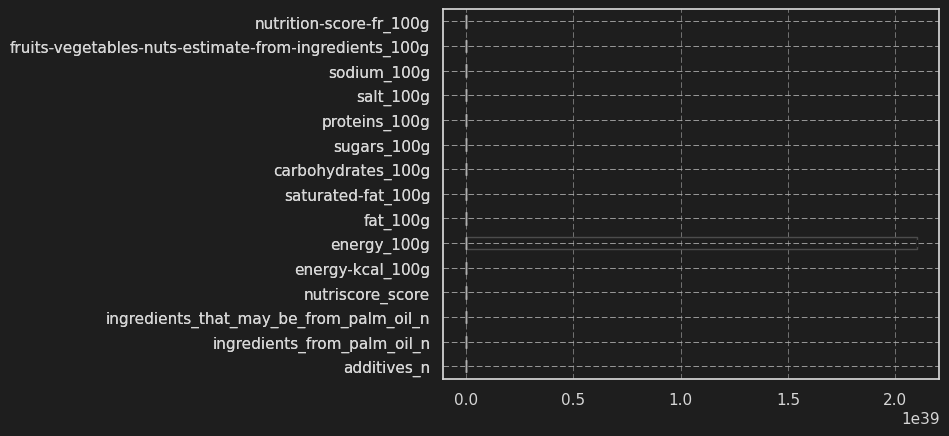

In [22]:
df_describe = data[categories_float].describe()
df_describe.boxplot( showfliers=False, vert=False )

IQs = df_describe.loc['75%', :] - df_describe.loc['25%', :]


# display(IQs)
df_describe = pd.concat( (df_describe, IQs.to_frame().T) , ignore_index=False )
df_describe.rename( index={0:'IQ'}, inplace=True )
display( df_describe )

key = 'energy_100g'
data.loc[ data[key] > df_describe[key]['75%'] + 1.5*df_describe[key]['IQ'] , key ] = np.nan

df_describe = data[categories_float].describe()
df_describe.boxplot( showfliers=False, vert=False )
display( df_describe )


# Labels
Several labels per product

In [24]:
key = 'labels_en'

print('Example of labels:\n')
i = 0
for value in data[key]:
        if value is np.nan : continue
        print(value)
        i += 1
        if i == 10: break
dico_value_labels = tools.value_count_labels_in_string_series( data.loc[~data[key].isnull(),key] , ',' )
print(dico_value_labels)

Example of labels:

Organic
No gluten
Organic,Made in France
Organic
No preservatives,Haute Valeur Environnementale
Low or no sugar,No sugar
Organic,EU Organic,No colorings,AB Agriculture Biologique
No gluten
Organic,EU Organic,FR-BIO-01
Made in Germany
{'Organic': 57511, 'No gluten': 14687, 'Made in France': 10170, 'No preservatives': 13007, 'Haute Valeur Environnementale': 17, 'Low or no sugar': 1138, 'No sugar': 449, 'EU Organic': 34382, 'No colorings': 9675, 'AB Agriculture Biologique': 13515, 'FR-BIO-01': 8836, 'Made in Germany': 2582, 'French meat': 4439, 'French pork': 2444, 'Green Dot': 15937, 'In braille': 386, 'FR-BIO-10': 1785, 'PGI': 1550, 'fr:deconseille-aux-femmes-enceintes': 954, 'de:mischung-von-honig-aus-eu-ländern': 1, 'PDO': 2037, 'fr:comte': 12, 'fr:eco-emballages': 1163, 'FSC': 2053, 'FSC Recycling': 20, 'Ab': 13, 'Vegetarian': 14964, 'European Vegetarian Union': 1033, 'European Vegetarian Union Vegetarian': 63, 'FSC Mix': 977, 'BE-BIO-01': 881, 'CH-BIO-006': 694, 

# A REGARDER

df = pd.DataFrame({"value": np.random.randint(0, 100, 20)})

labels = ["{0} - {1}".format(i, i + 9) for i in range(0, 100, 10)]

df["group"] = pd.cut(df.value, range(0, 105, 10), right=False, labels=labels)

df.head(10)
Out[9]: 
   value    group
0     65  60 - 69
1     49  40 - 49
2     56  50 - 59
3     43  40 - 49
4     43  40 - 49
5     91  90 - 99
6     32  30 - 39
7     87  80 - 89
8     36  30 - 39
9      8    0 - 9



s.str.contains('foo|bar', na=False, regex=False)
# na to manage nan (to False)
# regex=False to speed up, when regex-based search is not needed

# `axis=1` tells `apply` to apply the lambda function column-wise.
df.apply(lambda col: col.str.contains('foo|bar', na=False), axis=1)

terms = ['foo', 'baz']
df4[df4['col'].str.contains('|'.join(terms))]

How do I select by partial string from a pandas DataFrame?
This post is meant for readers who want to

search for a substring in a string column (the simplest case) as in df1[df1['col'].str.contains(r'foo(?!$)')]
search for multiple substrings (similar to isin), e.g., with df4[df4['col'].str.contains(r'foo|baz')]
match a whole word from text (e.g., "blue" should match "the sky is blue" but not "bluejay"), e.g., with df3[df3['col'].str.contains(r'\bblue\b')]
match multiple whole words
Understand the reason behind "ValueError: cannot index with vector containing NA / NaN values" and correct it with str.contains('pattern',na=False)
...and would like to know more about what methods should be preferred over others.

(P.S.: I've seen a lot of questions on similar topics, I thought it would be good to leave this here.)

Friendly disclaimer, this is post is long.

Basic Substring Search
# setup
df1 = pd.DataFrame({'col': ['foo', 'foobar', 'bar', 'baz']})
df1

      col
0     foo
1  foobar
2     bar
3     baz
str.contains can be used to perform either substring searches or regex based search. The search defaults to regex-based unless you explicitly disable it.

Here is an example of regex-based search,

# find rows in `df1` which contain "foo" followed by something
df1[df1['col'].str.contains(r'foo(?!$)')]

      col
1  foobar
Sometimes regex search is not required, so specify regex=False to disable it.

#select all rows containing "foo"
df1[df1['col'].str.contains('foo', regex=False)]
# same as df1[df1['col'].str.contains('foo')] but faster.
   
      col
0     foo
1  foobar
Performance wise, regex search is slower than substring search:

df2 = pd.concat([df1] * 1000, ignore_index=True)

%timeit df2[df2['col'].str.contains('foo')]
%timeit df2[df2['col'].str.contains('foo', regex=False)]

6.31 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.8 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Avoid using regex-based search if you don't need it.

Addressing ValueErrors
Sometimes, performing a substring search and filtering on the result will result in

ValueError: cannot index with vector containing NA / NaN values
This is usually because of mixed data or NaNs in your object column,

s = pd.Series(['foo', 'foobar', np.nan, 'bar', 'baz', 123])
s.str.contains('foo|bar')

0     True
1     True
2      NaN
3     True
4    False
5      NaN
dtype: object


s[s.str.contains('foo|bar')]
# ---------------------------------------------------------------------------
# ValueError                                Traceback (most recent call last)
Anything that is not a string cannot have string methods applied on it, so the result is NaN (naturally). In this case, specify na=False to ignore non-string data,

s.str.contains('foo|bar', na=False)

0     True
1     True
2    False
3     True
4    False
5    False
dtype: bool
How do I apply this to multiple columns at once?
The answer is in the question. Use DataFrame.apply:

# `axis=1` tells `apply` to apply the lambda function column-wise.
df.apply(lambda col: col.str.contains('foo|bar', na=False), axis=1)

       A      B
0   True   True
1   True  False
2  False   True
3   True  False
4  False  False
5  False  False
All of the solutions below can be "applied" to multiple columns using the column-wise apply method (which is OK in my book, as long as you don't have too many columns).

If you have a DataFrame with mixed columns and want to select only the object/string columns, take a look at select_dtypes.

Multiple Substring Search
This is most easily achieved through a regex search using the regex OR pipe.

# Slightly modified example.
df4 = pd.DataFrame({'col': ['foo abc', 'foobar xyz', 'bar32', 'baz 45']})
df4

          col
0     foo abc
1  foobar xyz
2       bar32
3      baz 45

df4[df4['col'].str.contains(r'foo|baz')]

          col
0     foo abc
1  foobar xyz
3      baz 45
You can also create a list of terms, then join them:

terms = ['foo', 'baz']
df4[df4['col'].str.contains('|'.join(terms))]

          col
0     foo abc
1  foobar xyz
3      baz 45
Sometimes, it is wise to escape your terms in case they have characters that can be interpreted as regex metacharacters. If your terms contain any of the following characters...

. ^ $ * + ? { } [ ] \ | ( )
Then, you'll need to use re.escape to escape them:

import re
df4[df4['col'].str.contains('|'.join(map(re.escape, terms)))]

          col
0     foo abc
1  foobar xyz
3      baz 45
re.escape has the effect of escaping the special characters so they're treated literally.

re.escape(r'.foo^')
# '\\.foo\\^'


# END OF NOTEBOOK

In [ ]:
fig = ax.get_figure()
fig.tight_layout()
tools.savefig( fig, 'Figures/test' )